## This Jupyter notebook answers HW01 questions for PHY 981 Nuclear Structure.

Author: Jacob Davison\
Date:   01/19/2021

In [1]:
# load packages

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

### HW01 question 3

The experimental binding energies are contained in the text file aud16.dat. Make a
plot that compares the experimental binding energies for the calcium isotopes to the
liquid drop model of Eq. 6.6.

In [2]:
# load the text file aud16.csv into dataframe
binding_df = pd.read_csv('aud16.csv')

# combine error prefix and O columns
binding_df['error BE (keV)'] = binding_df.apply(lambda row: "{:0.2f}{:d}".format(row['error prefix (keV)'], int(row['O'])), 
                                                axis=1)
binding_df['error BE (keV)'] = binding_df['error BE (keV)'].astype(float)

# add row computing BE from liquid drop model, Eq 6.6
binding_df['BE predict (keV)'] = binding_df.apply(lambda row: 
                                                  15.49*1e3*row['A'] - 
                                                  17.23*1e3*row['A']**(2/3) - 
                                                  0.697*1e3*row['Z']**2/row['A']**(1/3) - 
                                                  22.60*1e3*(row['N']-row['Z'])**2/row['A']
                                                  , axis=1)

# drop the prefix and O column for clarity
binding_df = binding_df.drop(columns=['error prefix (keV)', 'O'])

# drop the Z = 3, N = 200 row (neutron-saturated Li?)
binding_df = binding_df.drop(24, axis=0).reset_index().drop(columns=['index'])

binding_df

,Z,A,BE (keV),N,BE/A (keV),error BE (keV),BE predict (keV)
0,1,2,2224.566,1,1112.283,0.001,3.075871e+03
1,1,3,8481.795,2,2827.265,0.001,2.613550e+03
2,1,4,6881.796,3,1720.449,100.001,-4.495962e+03
3,1,5,6681.795,4,1336.359,89.441,-1.401843e+04
4,1,6,5769.834,5,961.639,254.121,-2.460245e+04
...,...,...,...,...,...,...,...
3428,117,293,2078835.000,176,7095.000,-879.001,2.073450e+06
3429,117,294,2085048.000,177,7092.000,-588.001,2.080608e+06
3430,118,293,2073561.000,175,7077.000,-586.001,2.066684e+06
3431,118,294,2081226.000,176,7079.000,-588.001,2.074116e+06


In [3]:
# get the calcium isotopes in the data table
calcium_iso = binding_df[binding_df['Z'] == 20]
calcium_iso

,Z,A,BE (keV),N,BE/A (keV),error BE (keV),BE predict (keV)
350,20,34,244936.000,14,7204.000,-306.001,235840.586273
351,20,35,262045.000,15,7487.000,-210.001,256416.154361
352,20,36,281371.625,16,7815.878,40.001,275306.091788
353,20,37,296127.875,17,8003.456,0.631,292648.010568
354,20,38,313121.625,18,8240.043,0.191,308565.017848
355,20,39,326417.125,19,8369.670,0.581,323167.575865
356,20,40,342052.125,20,8551.303,0.041,336555.082941
357,20,41,350414.938,21,8546.706,0.121,348817.223139
358,20,42,361895.656,22,8616.563,0.171,360035.123129
359,20,43,369828.500,23,8600.663,0.211,370282.347639


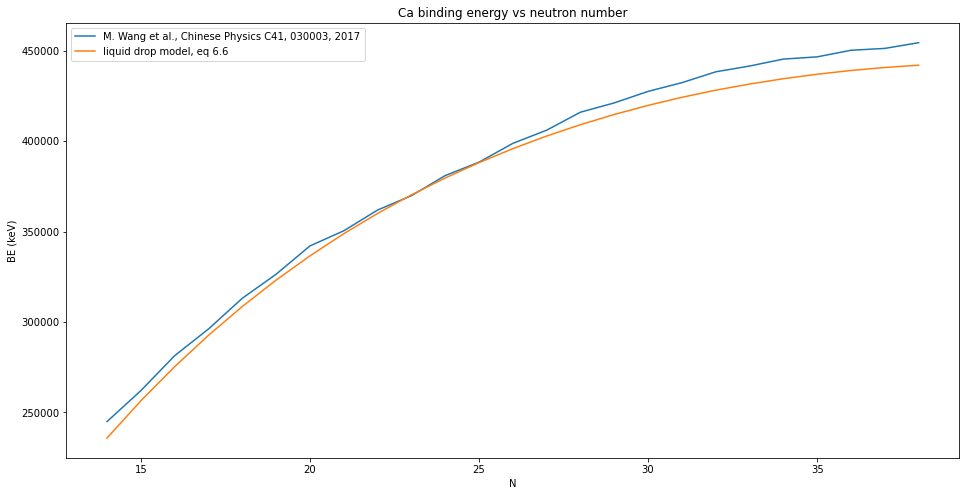

In [4]:
fig = plt.figure(figsize=(16,8))

sns.lineplot(x='N', y='BE (keV)', data=calcium_iso)
sns.lineplot(x='N', y='BE predict (keV)', data=calcium_iso)
plt.ylabel('BE (keV)')
plt.title('Ca binding energy vs neutron number')
plt.legend(['M. Wang et al., Chinese Physics C41, 030003, 2017', 'liquid drop model, eq 6.6'])

Text(0, 0.5, 'BE experiment - BE predict (keV)')

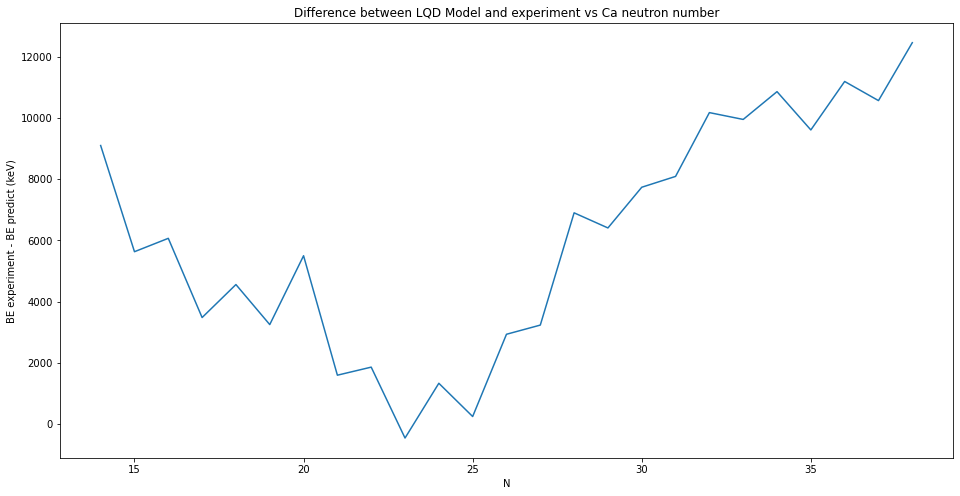

In [5]:
fig = plt.figure(figsize=(16,8))

sns.lineplot(x=calcium_iso['N'], y=calcium_iso['BE (keV)']-calcium_iso['BE predict (keV)'], data=calcium_iso)
plt.title('Difference between LQD Model and experiment vs Ca neutron number')
plt.ylabel('BE experiment - BE predict (keV)')

Difference between experiment and theory in binding energy for Ca is largest for large neutron number, e.g. 12 MeV around N=38. The difference drops almost to zero in the region N=23, likely because in this region, the symmetry energy term in the liquid drop model is smallest.

### HW01 question 4

Find the proton and neutron drip lines for calcium isotopes from the liquid drop model.
How do they compare with experiment?

In [6]:
# Let's compute neutron separation energy grouping by Z

def one_nucleon_sep(z_aggregate, name):
    original_indices = z_aggregate.index
    z_aggregate = z_aggregate.reset_index()
    
    num_iso = z_aggregate.shape[0]
    lqd_be = z_aggregate['BE predict (keV)']
    exp_be = z_aggregate['BE (keV)']

    lqd_sep = []  
    exp_sep = []
    for i in reversed(range(num_iso)):
        try:
            lqd_sep.append(lqd_be[i]-lqd_be[i-1])
            exp_sep.append(exp_be[i]-exp_be[i-1])
        except KeyError:
            lqd_sep.append(np.nan)
            exp_sep.append(np.nan)
    
    z_aggregate['S_{} predict (keV)'.format(name)] = lqd_sep[::-1]
    z_aggregate['S_{} experiment (keV)'.format(name)] = exp_sep[::-1]
    
    z_aggregate.index = original_indices
    
    return z_aggregate    

In [7]:
table_list = []
for Z in binding_df['Z'].unique():
    z_aggregate = binding_df[binding_df['Z'] == Z]
    table_list.append(one_nucleon_sep(z_aggregate, 'n'))
    
binding_sep_df = pd.concat(table_list)

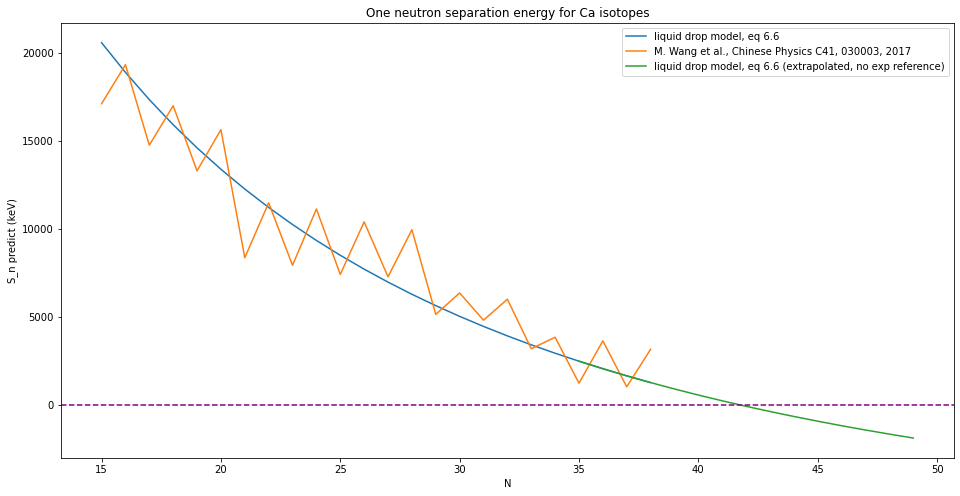

In [8]:
def eq6_6(N,Z):
    A = N+Z
    return 15.49*1e3*A - 17.23*1e3*A**(2/3) - 0.697*1e3*Z**2/A**(1/3) - 22.60*1e3*(N-Z)**2/A

fig = plt.figure(figsize=(16,8))

data = binding_sep_df[(binding_sep_df['Z'] == 20)]# & (binding_sep_df['Z'] == 21)]

n_data_extrap = list(range(35,50))
y_data_extrap = [eq6_6(N,20)-eq6_6(N-1,20) for N in n_data_extrap]


sns.lineplot(x='N', y='S_n predict (keV)', data=data)
sns.lineplot(x='N', y='S_n experiment (keV)', data=data)
sns.lineplot(x=n_data_extrap, y=y_data_extrap)

plt.axhline(0, color='purple', linestyle='--')

plt.title('One neutron separation energy for Ca isotopes')
plt.legend(['liquid drop model, eq 6.6', 'M. Wang et al., Chinese Physics C41, 030003, 2017', 'liquid drop model, eq 6.6 (extrapolated, no exp reference)'])

The 1 neutron drip line occurs around N=42 according to the liquid drop model. This result is based on LDM 
extrapolation with no experimental reference, because the data given by `aud16.dat` does not contain enough isotopes of Ca to determine the 1 neutron drip line empirically.

In [9]:
# We will now compute one proton separation energies by sorting by N
binding_sep_df = binding_sep_df.sort_values(by=['N','Z'])

In [10]:
table_list = []
for N in binding_sep_df['N'].unique():
    z_aggregate = binding_sep_df[binding_sep_df['N'] == N]
    table_list.append(one_nucleon_sep(z_aggregate, 'p'))
    
binding_sep_df = pd.concat(table_list)
binding_sep_df.head(10)

,level_0,index,Z,A,BE (keV),N,BE/A (keV),error BE (keV),BE predict (keV),S_n predict (keV),S_n experiment (keV),S_p predict (keV),S_p experiment (keV)
0,0,0,1,2,2224.566,1,1112.283,0.001,3075.870608,NaN,NaN,NaN,NaN
6,6,6,2,3,7718.040,1,2572.680,0.001,1163.731163,NaN,NaN,-1912.139445,5493.474
14,14,14,3,4,4615.040,1,1153.760,212.131,-8008.621752,NaN,NaN,-9172.352915,-3103.000
24,24,24,4,5,90.000,1,18.000,-2005.001,-20132.554793,NaN,NaN,-12123.933040,-4525.040
36,36,36,5,6,-2802.000,1,-467.000,-2004.001,-33808.220217,NaN,NaN,-13675.665424,-2892.000
1,1,1,1,3,8481.795,2,2827.265,0.001,2613.549587,-462.321021,6257.229,NaN,NaN
7,7,7,2,4,28295.660,2,7073.915,0.001,16786.790677,15623.059514,20577.620,14173.241090,19813.865
15,15,15,3,5,26330.660,2,5266.132,50.001,18880.701716,26889.323469,21715.620,2093.911039,-1965.000
25,25,25,4,6,26923.482,2,4487.247,5.451,14843.944722,34976.499514,26833.482,-4036.756995,592.822
37,37,37,5,7,24910.936,2,3558.705,25.151,7213.962331,41022.182548,27712.936,-7629.982391,-2012.546


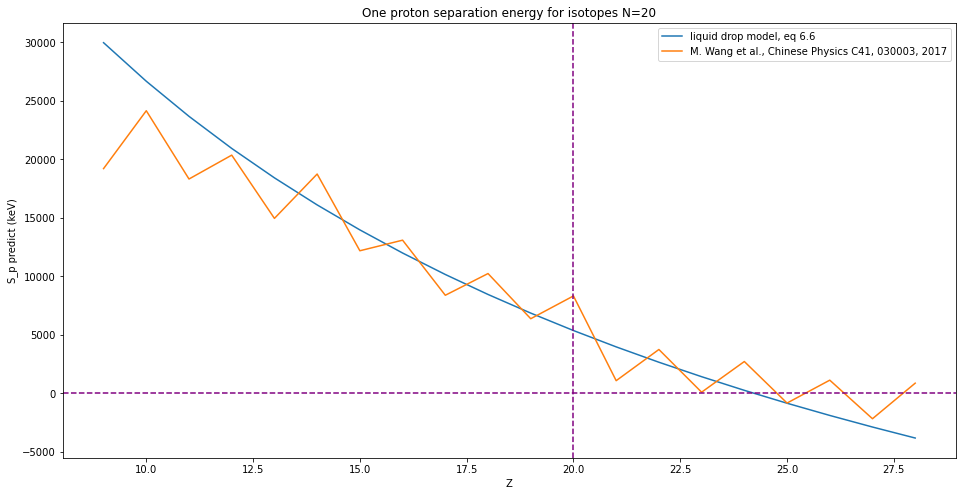

In [11]:
fig = plt.figure(figsize=(16,8))

sns.lineplot(x='Z', y='S_p predict (keV)', 
             data=binding_sep_df[binding_sep_df['N'] == 20], 
             ci=None)
sns.lineplot(x='Z', y='S_p experiment (keV)', 
             data=binding_sep_df[binding_sep_df['N'] == 20], 
             ci=None)

plt.title('One proton separation energy for isotopes N=20')
plt.axvline(20, color='purple', linestyle='--')
plt.axhline(0, color='purple', linestyle='--')
plt.legend(['liquid drop model, eq 6.6', 'M. Wang et al., Chinese Physics C41, 030003, 2017'])

If we fix N=20 and compute the 1 proton separation energy, we see that empirically and theoretically the 1 proton drip line occurs between Z=24 and Z=25. These are only a few protons away from Ca.

### HW01 question 5

Find the three liquid-model coefficients α 1 , α 2 and α 4 and their errors from a fit to the
experimental binding energies.

In [12]:
# We will use the original table here to keep things simple. It's already ordered by A.
from scipy.optimize import curve_fit

def ldm_3(x, a, b, c):
    Z = x['Z']
    N = x['N']
    A = Z + N
    
    return a*A - b*A**(2/3) - 0.697*1000*Z**2/A**(1/3) - c*(N - Z)**2/A

fit_data = binding_df[(abs(binding_df['error BE (keV)']) < 100) & 
                      (binding_df['Z'] <= 50) &
                      (binding_df['N'] < 200)].reset_index()

x_data = fit_data[['Z', 'N']]
y_data = fit_data['BE (keV)']
y_err = fit_data['error BE (keV)']

popt, pcov = curve_fit(ldm_3, x_data, y_data)
perr = np.sqrt(np.diag(pcov))

y_pred = ldm_3(x_data, *popt)

RMS_dev = np.sqrt(np.mean((y_data-y_pred)**2))

for i, p in enumerate(popt):
    print(u"p{:d} = {:d} \u00B1 {:d} keV".format(i, int(p), int(perr[i])))
    
print('chi-squared = {:0.2f}'.format(sum((y_data-y_pred)**2/(y_err+RMS_dev)**2)))

p0 = 15466 ± 15 keV
p1 = 16858 ± 66 keV
p2 = 22037 ± 82 keV
chi-squared = 943.77


LDM parameters fit from experiment (up to symmetry energy term):

$\alpha_1$ = 15466 $\pm$ 15 keV\
$\alpha_2$ = 16858 $\pm$ 66 keV\
$\alpha_4$ = 22037 $\pm$ 82 keV

$\chi^2_{reduced} = 943.77$

I computed the reduced chi-squared goodness of fit, but I added the RMS deviation (between experiment and theory) to the error in an attempt to bring the chi-squared value closer to 1. In other words, 

$$\chi^2_{reduced} = \sum_i^M\frac{(O_i - C_i)^2}{(\sigma_i +  \sigma_{RMS})^2}$$

where $M$ is the number of observations (956 in this case), $O_i$ is the ith observation, $C_i$ is the ith predicted value from the fit, $\sigma_i$ is the error of the ith observation (experimental error), and $\sigma_{RMS}$ is the root-mean-square deviation between experiment and theory. This sort of worked, but the $\chi^2$ is still far from 1.

In [13]:
# Here we extrapolate predictions to Z > 50

extrap_data = binding_df[(abs(binding_df['error BE (keV)']) < 100) & 
                          (binding_df['Z'] > 50)].reset_index()
#                           (binding_df['N'] < 200)].reset_index()

x_data_extrap = extrap_data[['Z', 'N']]
y_data_extrap = extrap_data['BE (keV)']

y_pred_extrap = ldm_3(x_data_extrap, *popt)

Text(0.68, 0.6, 'RMS difference: 3826.98 keV')

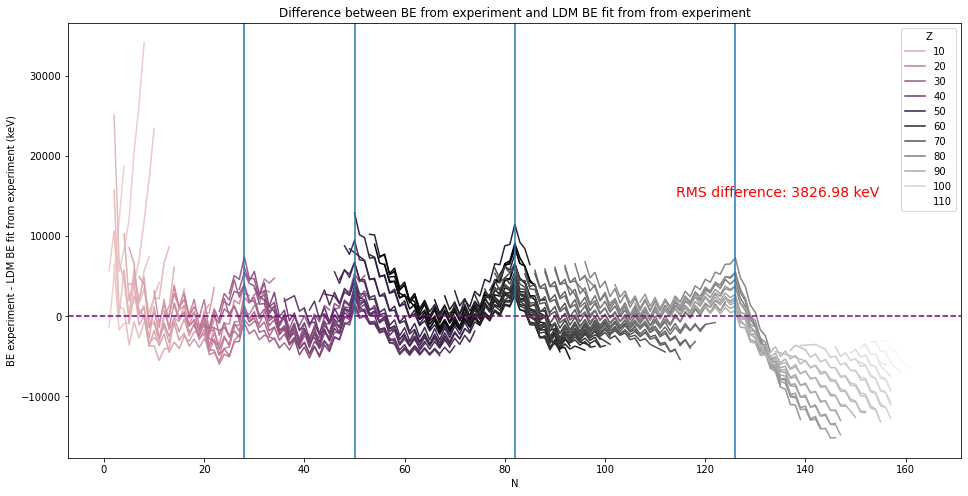

In [14]:
fig = plt.figure(figsize=(16,8))
sns.lineplot(x=x_data['N'], y=y_data-y_pred, hue=x_data['Z'])
sns.lineplot(x=x_data_extrap['N'], y=y_data_extrap-y_pred_extrap, hue=x_data_extrap['Z'], palette='gray')

plt.ylabel('BE experiment - LDM BE fit from experiment (keV)')
plt.title('Difference between BE from experiment and LDM BE fit from from experiment')
plt.axhline(0, color='purple', linestyle='--')
# plt.axhline(RMS_dev, color='red')
for N in [28, 50, 82, 126]:
    plt.axvline(N)
plt.text(0.68, 0.6, 
         'RMS difference: {:0.2f} keV'.format(RMS_dev),
         color='red',
         fontsize=14, 
         transform=fig.axes[0].transAxes)

This is the difference in binding energy between experiment and the LDM prediction. Note that the data in shades of purple contain data on which the LDM was fit. The data in shades of gray contains LDM *extrapolated* data. The vertical lines are the magic numbers N=28,50,82,126. Each individual curve is a fixed value of Z. I have also annotated the RMS deviation of the *fitted* data (excluding extrapolated data).

### HW01 question 6

Redo the liquid drop fit with the extra term $\alpha_5(N − Z)^4 /A^3$.

This question is a complete copy of question 5, but with the extra term representing even-odd oscillations in the binding energy due to the pairing interaction (I think).

In [15]:
# Same procedure as question 5, but editing function to extra term
def ldm_4(x, a, b, c, d):
    Z = x['Z']
    N = x['N']
    A = Z + N
    
    return a*A - b*A**(2/3) - 0.697*1000*Z**2/A**(1/3) - c*(N - Z)**2/A - d*(N-Z)**4/A**3

fit_data = binding_df[(abs(binding_df['error BE (keV)']) < 100) & 
                      (binding_df['Z'] <= 50) &
                      (binding_df['N'] < 200)].reset_index()

x_data = fit_data[['Z', 'N']]
y_data = fit_data['BE (keV)']

popt, pcov = curve_fit(ldm_4, x_data, y_data)
perr = np.sqrt(np.diag(pcov))

y_pred = ldm_4(x_data, *popt)

RMS_dev = np.sqrt(np.mean((y_data-y_pred)**2))

for i, p in enumerate(popt):
    print(u"p{:d} = {:d} \u00B1 {:d} keV".format(i, int(p), int(perr[i])))
    
print('chi-squared = {:0.2f}'.format(sum(((y_data-y_pred)**2/(y_err+RMS_dev)**2))))

p0 = 15577 ± 11 keV
p1 = 17218 ± 49 keV
p2 = 24890 ± 111 keV
p3 = -40999 ± 1356 keV
chi-squared = 947.48


LDM parameters fit from experiment (up to even-odd oscillation energy term):

$\alpha_1$ = 15577 $\pm$ 11 keV\
$\alpha_2$ = 17218 $\pm$ 49 keV\
$\alpha_4$ = 24890 $\pm$ 82 keV\
$\alpha_5$ = -40999 $\pm$ 1356 keV\
$\chi^2_{reduced}$ = 947.48

It's worth noting that the $\alpha_5$ term wants to be positive. In this fit, where the fifth LDM is term is explicitly negative, the $\alpha_5$ < 0, which makes the entire term positive. If I fit according to an explicitly positive fifth LDM term, the $\alpha_5$ > 0. My reduced chi-squared is slightly worse than the previous fit.

In [16]:
# Here we extrapolate predictions to Z > 50

extrap_data = binding_df[(abs(binding_df['error BE (keV)']) < 100) & 
                          (binding_df['Z'] > 50)].reset_index()
#                           (binding_df['N'] < 200)].reset_index()

x_data_extrap = extrap_data[['Z', 'N']]
y_data_extrap = extrap_data['BE (keV)']

y_pred_extrap = ldm_4(x_data_extrap, *popt)

Text(0.68, 0.1, 'RMS difference: 2733.74 keV')

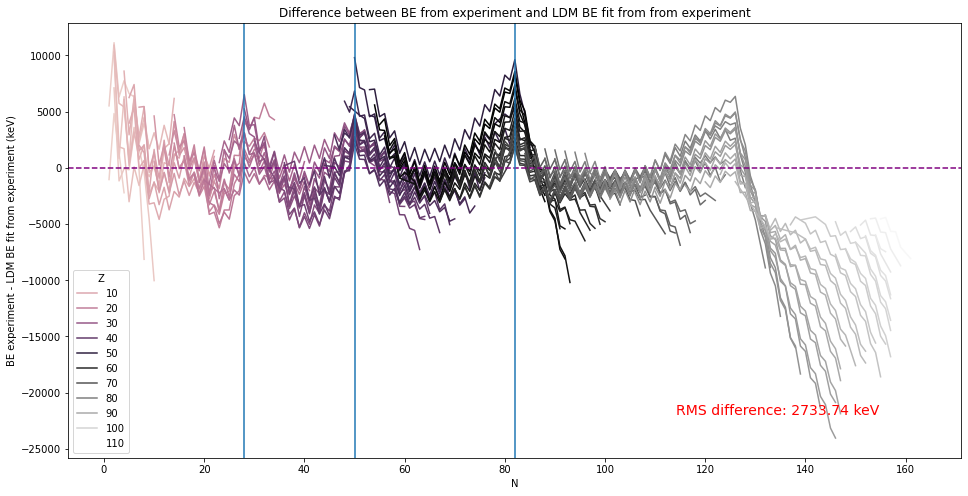

In [17]:
fig = plt.figure(figsize=(16,8))
sns.lineplot(x=x_data['N'], y=y_data-y_pred, hue=x_data['Z'])
sns.lineplot(x=x_data_extrap['N'], y=y_data_extrap-y_pred_extrap, hue=x_data_extrap['Z'], palette='gray')

plt.ylabel('BE experiment - LDM BE fit from experiment (keV)')
plt.title('Difference between BE from experiment and LDM BE fit from from experiment')
plt.axhline(0, color='purple', linestyle='--')
# plt.axhline(np.mean(y_data-y_pred), color='red')
for N in [28, 50, 82]:
    plt.axvline(N)
plt.text(0.68, 0.1, 
         'RMS difference: {:0.2f} keV'.format(RMS_dev),
         color='red',
         fontsize=14, 
         transform=fig.axes[0].transAxes)

The extra term shifts binding energies down such that RMS difference between experiment and theory is reduced for the *fitted* data. However, what we observe is that our LDM with the fifth term does not extrapolate to larger N as well as the four-term LDM. It seems that the five-term LDM is a better model for isotopes with medium mass.

### HW01 question 7

Derive Eq. 5.7. 

Eq. 5.7:  $F(q) \rightarrow 1 - \frac{R_{ch}^2}{6}q^2$

$$F(q) = \frac{4\pi}{Z} \int_0^\infty \rho_{ch}(r)\frac{sin(qr)}{qr}r^2 dr$$ 
where
$$Z = 4\pi \int_0^\infty \rho_{ch}(r)r^2 dr$$

Low-q expansion of $sin(qr)$, keeping up to order 3 term:

$$sin(qr) \approx qr - \frac{(qr)^3}{6} \implies F(q) \approx \frac{4\pi}{Z} \int_0^\infty \rho_{ch}(r)(1-\frac{(qr)^2}{6})r^2 dr.$$

Now we have:

$$F(q) \approx \frac{4\pi}{Z} \int_0^\infty \rho_{ch}(r)r^2 dr - \frac{4\pi}{Z}\int_0^\infty\rho_{ch}(r)\frac{(qr)^2}{6}r^2 dr.$$

First term on RHS is equal to 1 (we have $Z/Z$). We focus on the second term on the RHS now. 

Let 
$$P_{ch}(r) = \frac{4\pi}{Z}r^2\rho_{ch}(r)$$
so that $P_{ch}$ is the charge probability density (of proton in nucleus).

Then, the second term in the RHS becomes:

$$q^2 \int_0^\infty P_{ch}(r)\frac{r^2}{6} dr = \frac{R_{ch}^2}{6}q^2.$$

Finally, putting everything together, we can say that for low q

$$F(q) = 1 - \frac{R_{ch}^2}{6}q^2 \quad \blacksquare.$$

### HW01 question 8

In Fig. 5.4 the lowest point for $^{16}$O is at q = 0.290 fm$^{-1}$ with a value of |F|$^2$=0.810.
Use this to find the rms charge radius of $^{16}$O.

In [18]:
q = 0.290
Fsq = 0.810
F = np.sqrt(Fsq)

R = np.sqrt(6*(1 - F)/q**2)
print('rms charge radius R_ch = {:0.3f} fm'.format(R))

rms charge radius R_ch = 2.671 fm


The calculated RMS charge radius of $^{16}$O: $R_{ch}$ = 2.671 fm

### HW01 question 9

Show that the second derivative of the Fermi distribution in Eq. 5.11 is not zero at
the origin.

Eq 5.11 $$\rho_{ch}(r) = \frac{\rho_0}{1 + \exp\left[(r-c)/a\right]}$$

First derivative $D^{(1)}_r$:

$$D^{(1)}_r \rho_{ch}(r) = -\frac{\rho_0}{(1 + \exp\left[(r-c)/a\right])^2}\exp\left[(r-c)/a\right]\frac{1}{a}$$

Second derivative $D^{(2)}_r$:

$$D^{(2)}_r \rho_{ch}(r) = \frac{\rho_0}{a}\left(\frac{2\exp\left[(r-c)/a\right]}{(1 + \exp\left[(r-c)/a\right])^3}\exp\left[(r-c)/a\right]\frac{1}{a} - \frac{1}{a}\frac{\exp\left[(r-c)/a\right]}{(1 + \exp\left[(r-c)/a\right])^2}\right)$$

$$ = \frac{\rho_0}{a^2}\left(\frac{2\exp\left[(r-c)/a\right]^2}{(1 + \exp\left[(r-c)/a\right])^3} - \frac{\exp\left[(r-c)/a\right]}{(1 + \exp\left[(r-c)/a\right])^2}\right)$$

$$= \frac{\rho_0}{a^2}\frac{\exp\left[(r-c)/a\right]^2 - \exp\left[(r-c)/a\right]}{(1 + \exp\left[(r-c)/a\right])^3}$$

At origin $D^{(2)}_{r=0}$:

$$D^{(2)}_{r=0}\rho_{ch}(r) = \frac{\rho_0}{a^2}\frac{\exp\left[(-c)/a\right]^2 - \exp\left[(-c)/a\right]}{(1 + \exp\left[(-c)/a\right])^3} \ne 0 \quad \blacksquare.$$